# Optimizacion de Portafolios

## Contenido
- Descarga de datos
- Estimacion de parametros muestrales
- Modelos de Optimizacion Cuadratica
- - Minima Varianza Global
- - Minima Varianza con Rendimiento Minimo Admisible
- - Maximo Ratio de Sharpe
- Frontera Eficiente
- Modelo CAPM
- Security Market Line
- Modelo de 5 Factores de Fama-French
- Modelo de Factores estadisticos (Componentes Principales) [Proxima Clase]
- Modelo de Black Litterman [Proxima Clase]

In [ ]:
# !pip install pyportfolioopt
# !pip install cvxpy

### Preparacion de datos

In [162]:
# Importo librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf

In [163]:
# Defino algunas funciones para emprolijar los datos
def format_df(df):
    df.columns = [ '_'.join(x) for x in df.columns ]
    df = df.loc[:,df.columns.str.endswith('_Close')]
    df.columns = df.columns.str.replace(r'_Close$', '')
    return df

In [164]:
# Descargo algunos tickers de Yahoo Finance, y miro los primeros 5 registros

tickers = ['GOOG','AMZN','TSLA','NFLX','MELI', 'ORCL']

start_date = '2015-01-01'
end_date = '2023-04-30'  # dt.datetime.now()

asset_data_raw = yf.download(
    tickers = tickers,
    interval = '1d',
    start = start_date,
    end = end_date,
    group_by = 'ticker',
    auto_adjust = True,
    prepost = True,
    threads = True,
    )


asset_data = format_df(asset_data_raw)
asset_data.head()

[*********************100%***********************]  6 of 6 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_1872\607939786.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace(r'_Close$', '')


,GOOG,ORCL,AMZN,TSLA,MELI,NFLX
Date,,,,,,
2015-01-02,26.168653,38.697014,15.4260,14.620667,124.582489,49.848572
2015-01-05,25.623152,38.154312,15.1095,14.006000,123.048119,47.311428
2015-01-06,25.029282,37.760441,14.7645,14.085333,120.850464,46.501431
2015-01-07,24.986401,37.769192,14.9210,14.063333,120.612877,46.742859
2015-01-08,25.065184,37.996777,15.0230,14.041333,122.414574,47.779999


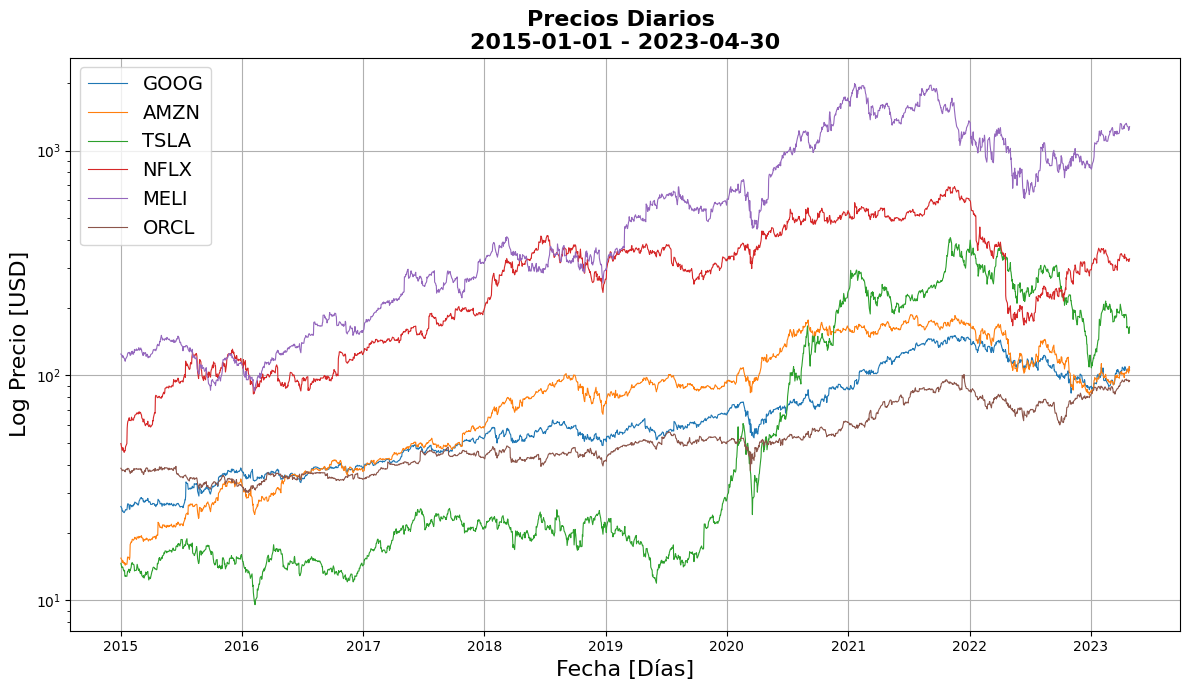

In [165]:
# Grafico las series de precios

fig, ax = plt.subplots(1,1, figsize = (12,7), tight_layout = True, dpi = 100)

plot_assets = tickers  #['AMZN','MELI','GOOG'] # esto era por si quieria ver menos assets de todos los que habiabajado

ax.set_title(f'Precios Diarios \n{start_date} - {end_date}', weight = 'bold', fontsize = 16)

ax.plot(asset_data.loc[:,plot_assets], lw = 0.8, label = plot_assets)

''' # Si quisiera personalizar aun mas los graficos, algunos ejemplos de como hacerlo:
ax.plot(asset_data.loc[:,'AMZN'], lw = 0.5, color = 'darkorange', label = 'Amazon')
#ax.plot(asset_data.loc[:,'TSLA'], lw = 0.5, color = 'blue', label = 'Tesla')
ax.plot(asset_data.loc[:,'GOOG'], lw = 0.5, color = 'darkgreen', label = 'Google')
ax.plot(asset_data.loc[:,'MELI'], lw = 0.5, color = 'blue', label = 'Mercado Libre')
'''

ax.semilogy()
ax.set_ylabel('Log Precio [USD]', fontsize = 16)
ax.set_xlabel('Fecha [Días]',fontsize = 16)
ax.grid()
ax.legend(ncol = 1,fontsize = 14)

In [166]:
# Busco precios mensuales:
# Muestreo los precios diarios quedandome con el del ultimo dia habil de cada mes ("BM": "Business Month")

monthly_prices = asset_data.asfreq(freq='BM').ffill()
monthly_prices.head()

,GOOG,ORCL,AMZN,TSLA,MELI,NFLX
Date,,,,,,
2015-01-30,26.652824,36.666309,17.726500,13.573333,122.691734,63.114285
2015-02-27,27.843555,38.355637,19.007999,13.556000,129.650909,67.844284
2015-03-31,27.324980,37.769192,18.605000,12.584667,121.389023,59.527142
2015-04-30,26.867001,38.314415,21.089001,15.070000,141.016144,79.500000
2015-05-29,26.605499,38.200237,21.461500,16.719999,143.790298,89.151428


### Vector de medias y matriz de covarianzas

In [167]:
# Importo librerias necesarias
from pypfopt import expected_returns
from pypfopt import risk_models

In [168]:
# Calculo el vector de medias y matriz de covarianzas anualizadas.
# Como pase datos menusales, frequency = 12; si hubiera pasado datos diariosn, frequency = 252. Los resultados no tienen por que coincidir, ya que los datos diarios son mas ruidosos.
mean_returns_annualized = expected_returns.mean_historical_return(monthly_prices,frequency=12)
covariance_matrix_annualized = risk_models.sample_cov(monthly_prices, frequency = 12)

In [169]:
# Visualizacion del vector de medias
mean_returns_annualized

GOOG    0.185128
ORCL    0.121917
AMZN    0.241279
TSLA    0.352913
MELI    0.328429
NFLX    0.221985
dtype: float64

In [ ]:
# Visualizacion de la matriz de covarianzas

In [170]:
covariance_matrix_annualized

,GOOG,ORCL,AMZN,TSLA,MELI,NFLX
GOOG,0.060693,0.025187,0.051915,0.055997,0.050458,0.045325
ORCL,0.025187,0.051421,0.028680,0.029962,0.035180,0.038889
AMZN,0.051915,0.028680,0.102255,0.085032,0.071464,0.085254
TSLA,0.055997,0.029962,0.085032,0.399578,0.107178,0.084728
MELI,0.050458,0.035180,0.071464,0.107178,0.210822,0.085335
NFLX,0.045325,0.038889,0.085254,0.084728,0.085335,0.184712


In [171]:
# Las volatilidades individuales son la varianza de cada activo y ellas se encuentran en la diagonal de la matriz de covarianzas. Las tomo de ahi directamente en vez de calcularlas una por una:
volatility_annualized = np.sqrt(np.diag(covariance_matrix_annualized))
volatility_annualized = pd.DataFrame(volatility_annualized, index = covariance_matrix_annualized.columns)
volatility_annualized

,0
GOOG,0.246359
ORCL,0.226763
AMZN,0.319773
TSLA,0.632122
MELI,0.459154
NFLX,0.429781


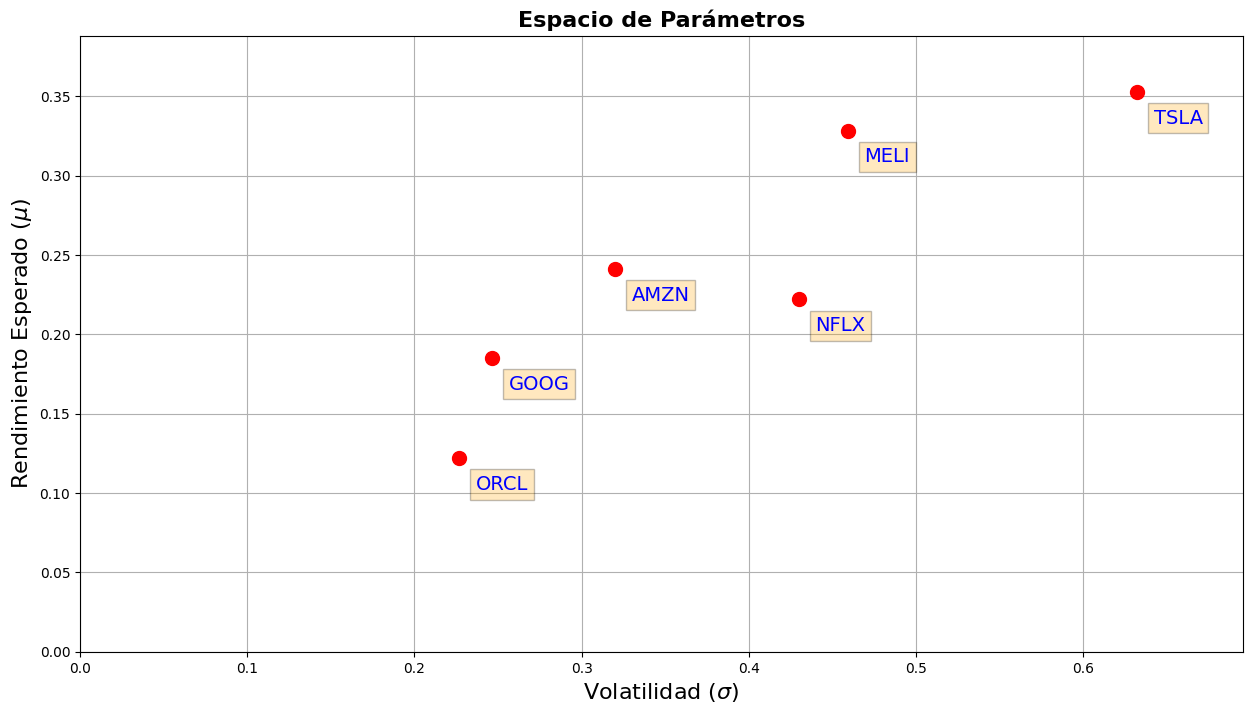

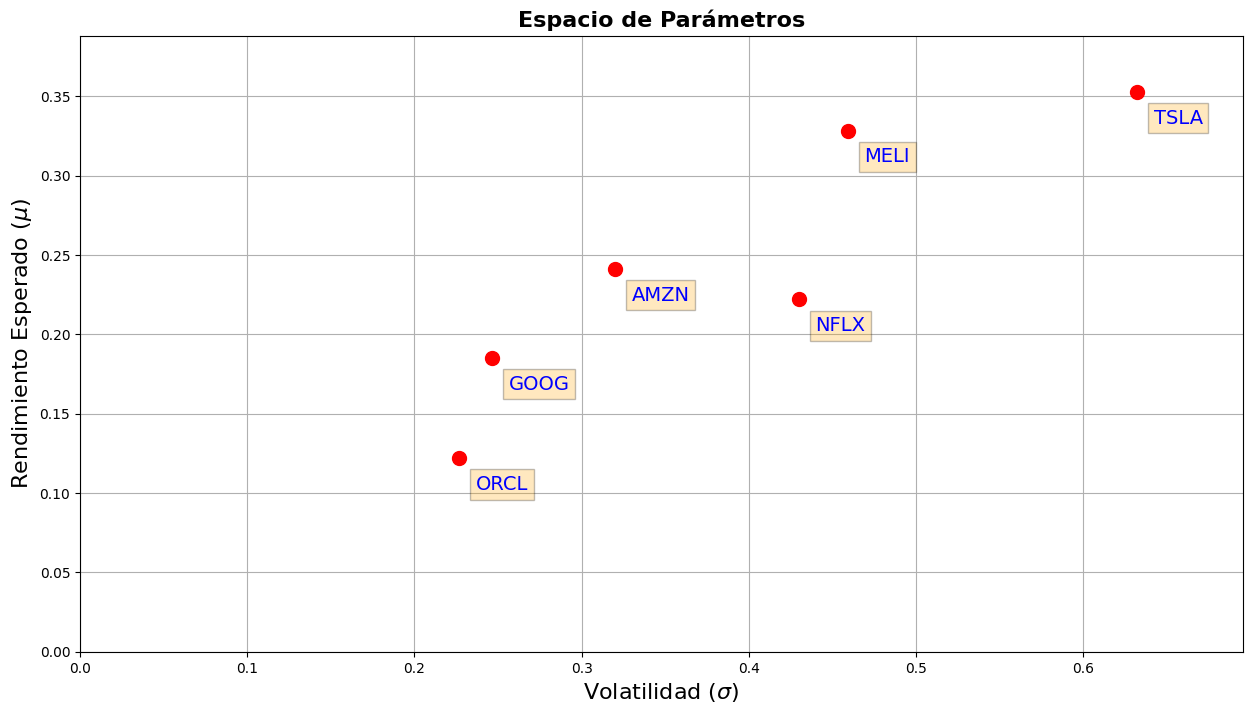

In [173]:
# Visualizacion de activos en el plano riesgo-rendimiento

fig, ax = plt.subplots(1,1, figsize = (15,8), dpi = 100)

for i in range(len(tickers)):
    ax.plot(volatility_annualized.to_numpy()[i], mean_returns_annualized.to_numpy()[i],
               markersize = 10, marker="o", markeredgecolor= 'red', markerfacecolor= 'red')

    ax.text(x =volatility_annualized.to_numpy()[i] + 0.01, y = mean_returns_annualized[i] - 0.02, s = mean_returns_annualized.index[i],
             fontdict = dict(color = 'blue', alpha = 1, size = 14),
            bbox = dict(facecolor = 'orange', alpha = 0.25))



ax.set_xlim(0, 1.1 * np.max(volatility_annualized.to_numpy()))
ax.set_ylim(0, 1.1 * np.max(mean_returns_annualized.to_numpy()))


ax.set_ylabel('Rendimiento Esperado ($\mu$)', fontsize = 16)
ax.set_xlabel('Volatilidad ($\sigma$)', fontsize = 16)
ax.set_title('Espacio de Parámetros', weight = 'bold', fontsize = 16)
ax.grid()



### Portafolios

In [19]:
# Defino una funcion para obtener el riesgo y rendimiento deu n portafolio:
# Calculamos volatilidad y retorno de un portafolio
def portfolio_metrics(weights, mean_returns, cov_matrix):
    ret = np.sum(mean_returns * weights)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, std

# Defino una funcion para generar portafolios aleatorios, dado un vector de medias y una matriz de covarianzas
def random_portfolios(num_port, mean_returns, cov_matrix):
    metrics = np.zeros((2,num_port))
    weights_matrix = []

    for i in range(num_port):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_matrix.append(weights)
        port_mu, port_std = portfolio_metrics(weights, mean_returns, cov_matrix)
        metrics[0,i] = port_mu
        metrics[1,i] = port_std
    return metrics, weights_matrix

In [174]:
# Simmulo portafolios aleatorios y almaceno sus metricas de desempenio y sus composiciones (por separeado)

# Número de portafolios
np.random.seed(123)
num_sim_portfolios = int(1e4)

# Simulacion
metrics, weights_matrix = random_portfolios(num_port = num_sim_portfolios,
                                            mean_returns = mean_returns_annualized,
                                            cov_matrix = covariance_matrix_annualized)

### Optimizacion de portafolios

In [175]:
# Importo librerias
import cvxpy as cp

In [176]:
# Renombro las variables por comodidad:
mu = mean_returns_annualized
Sigma = covariance_matrix_annualized
n = len(mu)

In [177]:
# Calculo del portafolio de minima varianza global:

# Creo el vector de weights como variable de decision
w = cp.Variable(n)

# Creo el retorno del portafolio, pasando el vector de weights (variable de decision) y el vector de medias (dato)
ret = w.T @ mu   #mu.T @ w  # mu.T w    ==      w.T mu    (por ser escalar)

# Creo el riesgo del portafolio como una forma cuadratica, pasando el vector de weights (variable de decision) y la matriz de covarianzas (dato)
risk = cp.quad_form(w, Sigma)   # wT Sigma w

# Especifico las restricciones como una lista de condiciones booleanas
constraints = [cp.sum(w) == 1,  # Fully invested
               w >= 0]          # Long-Only

# Creo una instancia del porblema de optimizacion, pasando el objetivo, y las restricciones:
prob = cp.Problem(cp.Minimize(risk), constraints)

# Resuelvo el problema
prob.solve()

0.0402216393890713

In [178]:
# Convierto el modelo en una funcion que toma como parametros un vector de retornos esperados, unamatriz de covarianzas, y un rendimiento minimo admisible (ya no estoy en el caso de minima varianza global):

def optimize_portfolio(mean_returns_vec, covariance_matrix, base_portfolio_return):

    mu = mean_returns_vec
    Sigma = covariance_matrix
    n = len(mu)

    w = cp.Variable(n)

    ret = w.T @ mu   #mu.T @ w  # mu.T w    ==      w.T mu    (por ser escalar)
    risk = cp.quad_form(w, Sigma)   # wT Sigma w


    # Si pido minima varianza global, entonces es el problemade antes
    if base_portfolio_return == 'min_global_variance':
        constraints = [cp.sum(w) == 1,
                       w>=0]

    # por elcontrario, si pido un rendimiento minimo admisible, lo agrego como restriccion
    else:
        constraints = [ret >= base_portfolio_return,
                       cp.sum(w) == 1,
                       w>=0]

    prob = cp.Problem(cp.Minimize(risk), constraints)
    prob.solve()

    # Una vez que resuelvo el problema, guardo las variables relevantes en un diccionario por comodidad.
    return {"portfolio_risk": risk.value,
            "portfolio_return":ret.value,
            "weights": pd.DataFrame(w.value, index = mean_returns_vec.index).apply(lambda r: np.where(r <= 1e-06,0,r))}

In [182]:
# Pruebo la funcion con el portafolio de minima varianza global
min_global_variance_solution = optimize_portfolio(mean_returns_annualized, covariance_matrix_annualized, base_portfolio_return = 'min_global_variance')

display(min_global_variance_solution["portfolio_return"])
display(min_global_variance_solution["portfolio_risk"])
display(min_global_variance_solution["weights"])

0.1508625050635955

0.0402216393890713

,0
GOOG,0.400589
ORCL,0.569049
AMZN,0.030361
TSLA,0.000000
MELI,0.000000
NFLX,0.000000


In [184]:
# Ejemplo con otro rendimiento esperado
rendimiento_minimo_exigido = 0.2   # quizas no para todo rendimiento minimo encuentre una solucion para el vector de media y matriz de covarianza que hayamos pasado

optimal_portfolio = optimize_portfolio(mean_returns_annualized, covariance_matrix_annualized, base_portfolio_return = rendimiento_minimo_exigido)

display(np.sqrt(optimal_portfolio["portfolio_risk"]))
display(optimal_portfolio["portfolio_return"])
display(optimal_portfolio["weights"])

0.22175875636149467

0.19999999999999998

,0
GOOG,0.354375
ORCL,0.317044
AMZN,0.153864
TSLA,0.050482
MELI,0.124234
NFLX,0.000000


### Frontera eficiente

In [185]:
# Preparamos los datos para trazar una frontera eficiente

# Paso con el que voy a incrementar el rendimiento minimo exigido
step = 0.005
# Punto de comienzo de rendimiento para comenzar a trazar: el rendimiento del portafoliode minima varianza global, NO CERO!
min_return = min_global_variance_solution['portfolio_return']
# Punto para finalizar la traza: el rendimiento mas alto disponible en el mercado
max_return = np.max(mean_returns_annualized)

# Cantidad de puntos usados para trazar la frontera (sera la cantidad de portafolios optimos a resolver)
num_efficient_points = 60

# Creo un vector de rendimientos exigidos para barrer la frontera
mu_range = np.linspace(start=min_return, stop=max_return, num=num_efficient_points, endpoint=True)

# Creo estructuras vacias para ir guardando los renimientos minimos exigidos y las volatilidades optimizadas
efficient_risk = np.zeros(num_efficient_points)
efficient_return = np.zeros(num_efficient_points)

In [186]:
# Calculo de la frontera eficiente:
# Voy barriendo los rendimientosm inimos, resolviendo el probelma de optimizacion, y guardando las coordenadas optimas:
for i in range(num_efficient_points):
    solution = optimize_portfolio(mean_returns_annualized, covariance_matrix_annualized, base_portfolio_return = mu_range[i])
    efficient_risk[i] = np.sqrt(solution["portfolio_risk"])
    efficient_return[i] = solution["portfolio_return"]

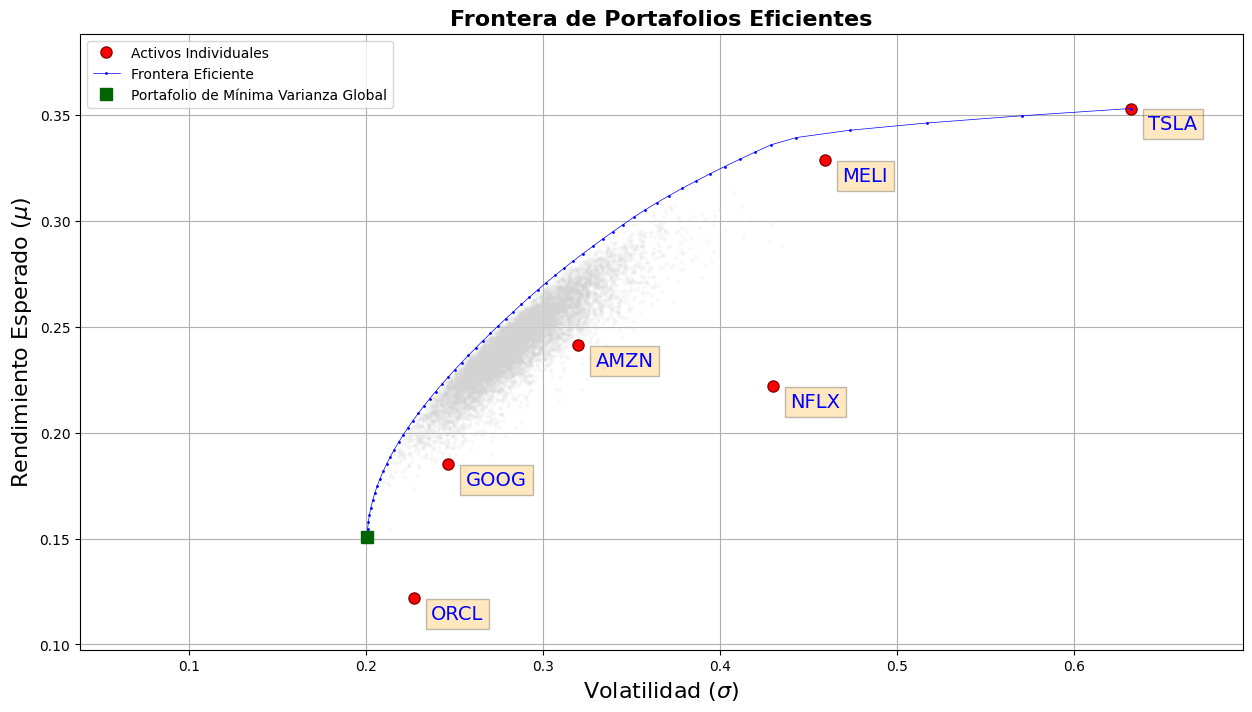

In [187]:
# Visualizacion de la frontera eficiente sobre el conjunto de lso portafolios simulados, y los otros activos individuales:

fig, ax = plt.subplots(1,1, figsize = (15,8), dpi = 100)

ax.plot(metrics[1,:], metrics[0,:], 'o', markersize = 2,  alpha = 0.1, color = 'lightgray')

ax.plot(volatility_annualized.to_numpy(), mean_returns_annualized.to_numpy(), "o",markersize = 8, markeredgecolor= 'darkred', markerfacecolor= 'red', label = 'Activos Individuales')

for i in range(len(tickers)):

    ax.text(x = volatility_annualized.to_numpy()[i] + 0.01, y = mean_returns_annualized[i] - 0.01, s = mean_returns_annualized.index[i],
            fontdict = dict(color = 'blue', alpha = 1, size = 14),
            bbox = dict(facecolor = 'orange', alpha = 0.25))


ax.set_xlim(0.95 * np.min(min_global_variance_solution["portfolio_risk"]), 1.1 * np.max(volatility_annualized.to_numpy()))
ax.set_ylim(0.8 * np.min(mean_returns_annualized), 1.1 * np.max(mean_returns_annualized))

ax.plot(efficient_risk, efficient_return, 'o-', markersize = 1, color = 'blue', lw = 0.5, label = 'Frontera Eficiente')

ax.plot(np.sqrt(min_global_variance_solution["portfolio_risk"]), min_global_variance_solution['portfolio_return'], 's', markersize = 8, color = 'darkgreen', label = 'Portafolio de Mínima Varianza Global')

ax.legend(loc = 'upper left')
ax.set_ylabel('Rendimiento Esperado ($\mu$)', fontsize = 16)
ax.set_xlabel('Volatilidad ($\sigma$)', fontsize = 16)
ax.set_title('Frontera de Portafolios Eficientes', weight = 'bold', fontsize = 16)
ax.grid()

In [188]:
# Busco el portafolio de maximo ratio de Sharpe

# Importo librerias:
import scipy.optimize as sco
from scipy import stats

# Defino funciones auxiliares:
## Calculo de rendimiento, volatilidad, y ratio de Sharpe
rf, mu, covmat = 0.01, mu, Sigma

def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(np.array(mu) * weights)
    vol = np.sqrt(np.dot(weights.T,np.dot(np.array(covmat),weights)))
    sr = (ret-rf)/vol
    return np.array([ret,vol,sr])

# Voy a minimizar el menos-ratio de sharpe
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

# Restriccion fully invested: suma de ponderaciones = 1 (booleano)
def check_sum(weights):
    return np.sum(weights) - 1

# Creo las restricciones del modelo:
## Una tupla con diccionarios, donde cada diccionario es una restriccion:
## - primera componente: si es de igualdad o de desigualdad
## - segunda compnente: una funcion que representa la restricccion. Debe ser una funcion que devuelve valores booleanos.
cons = ({'type':'eq','fun':check_sum})

# Creo cotas para los weights, en este caso,entre 0 y 1 para cada weight
bounds = ((0,1),) * len(mu)

# Puedo comenzar sugiriendo una solucion , para asistir el optimizador. En ese caso, sugeri que comience de un portafolio de ponderaciones uniformes ("equally weighted")
init_guess = [1/len(mu)] * len(mu)

# Resuelvo el problema
opt_results = sco.minimize(neg_sharpe, init_guess,
                           method='SLSQP', bounds=bounds, constraints=cons)

In [189]:
sharpe_weights = pd.DataFrame(opt_results['x'].T, index = mu.index).apply(lambda r: np.where(r<=1e-6,0,r))

sharpe_return, sharpe_risk = portfolio_metrics(opt_results['x'].T, mu, Sigma)

max_sr = -opt_results['fun']

display(print(f"Rendimiento: {sharpe_return}"))
display(print(f"Riesgo: {sharpe_risk}"))
display(print("Ratio de Sharpe:",max_sr))
display(sharpe_weights)

Rendimiento: 0.23383685190702397


None

Riesgo: 0.2547591617392721


None

Ratio de Sharpe: 0.8786214021857438


None

,0
GOOG,0.320236
ORCL,0.149274
AMZN,0.229344
TSLA,0.086257
MELI,0.214889
NFLX,0.000000


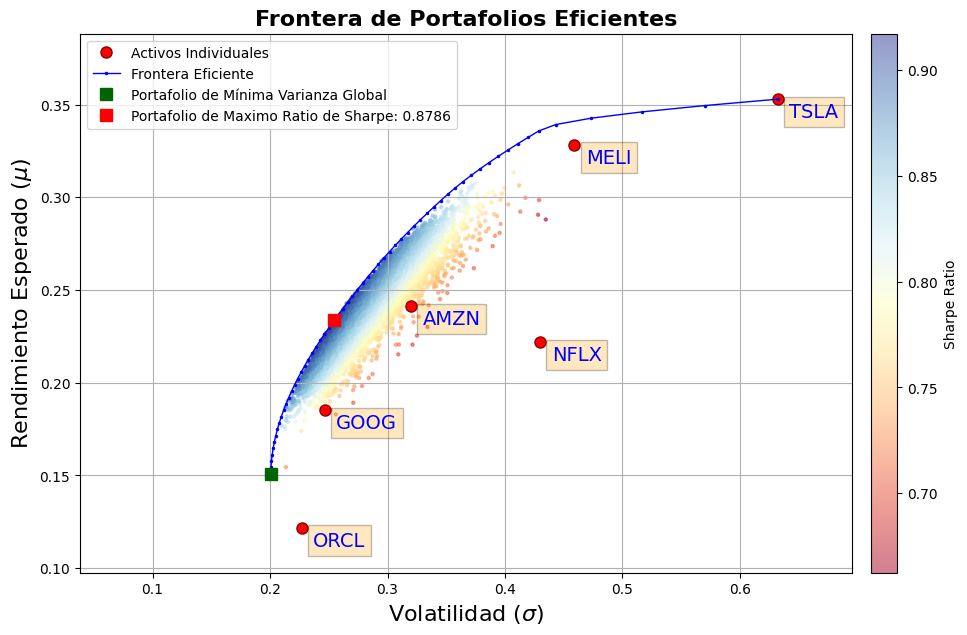

In [190]:
# Grafico la frontera eficiente, losp ortafolios aleatorios, los activos individuales, el protafolio de minima varianza global, y el portafolio de maximoratio de Sharpe:

## Ademas, cada punto del plano, que es un portafolio, sera coloreado de acuerdo a su propio ratio de sharpe (excepto el de MVG y los activos individuales)

fig, ax = plt.subplots(1,1, figsize = (12,7), dpi = 100)

sharpe = ax.scatter(metrics[1,:], metrics[0,:], s = 5, c=metrics[0,:]/metrics[1,:], cmap ='RdYlBu',  alpha = 0.5) #, color = 'lightgray'  'o', markersize = 2,
cbar = plt.colorbar(sharpe, pad = 0.02)
cbar.set_label('Sharpe Ratio')

ax.plot(volatility_annualized.to_numpy(), mean_returns_annualized.to_numpy(), "o",markersize = 8, markeredgecolor= 'darkred', markerfacecolor= 'red', label = 'Activos Individuales')

for i in range(len(tickers)):

    ax.text(x = volatility_annualized.to_numpy()[i] + 0.01, y = mean_returns_annualized[i] - 0.01, s = mean_returns_annualized.index[i],
            fontdict = dict(color = 'blue', alpha = 1, size = 14),
            bbox = dict(facecolor = 'orange', alpha = 0.25))


ax.set_xlim(0.95 * np.min(min_global_variance_solution["portfolio_risk"]), 1.1 * np.max(volatility_annualized.to_numpy()))
ax.set_ylim(0.8 * np.min(mean_returns_annualized), 1.1 * np.max(mean_returns_annualized))

ax.plot(efficient_risk, efficient_return, 'o-', markersize = 1.5, color = 'blue', lw = 1, label = 'Frontera Eficiente')

ax.plot(np.sqrt(min_global_variance_solution["portfolio_risk"]), min_global_variance_solution['portfolio_return'], 's', markersize = 8, color = 'darkgreen', label = 'Portafolio de Mínima Varianza Global')

ax.plot(sharpe_risk, sharpe_return, 's', markersize = 8, color = 'red', label = f'Portafolio de Maximo Ratio de Sharpe: {max_sr:.4f}')

ax.legend(loc = 'upper left')
ax.set_ylabel('Rendimiento Esperado ($\mu$)', fontsize = 16)
ax.set_xlabel('Volatilidad ($\sigma$)', fontsize = 16)
ax.set_title('Frontera de Portafolios Eficientes', weight = 'bold', fontsize = 16)
ax.grid()

### Repetir analisis con componentes del SP 500

In [191]:
# Defino 2 funciones auximilares de forma un poco mas prolija para: 1) calcular rendimientos; y 2) calcular media y covarianzas.
def return_fn(prices, resample_freq=None, type="log", since=None):
    if since is None:
        prices_ = prices
    else:
        prices_ = prices.loc[since:]

    if resample_freq is not None:
        prices_ = prices_.asfreq(resample_freq).ffill()
        #(resample_freq).last()

    if type == 'log':
        returns = prices_.apply(np.log).diff()
    else:
        returns = prices_.pct_change()

    returns.dropna(inplace = True)
    return returns

def mean_var_estimates(returns, freq = None):
    if freq is not None:
        mean_estimate = np.expm1(returns.mean()*freq)
        cov_estimate = returns.cov()*freq
    else:
        mean_estimate = np.expm1(returns.mean())
        cov_estimate = returns.cov()
    return mean_estimate, cov_estimate

In [192]:
# Bajo componentes del SP 500
np.random.seed(123)

# definimos el universo de activos para trabajar
#tickers = ['GOOG','AMZN','TSLA','NFLX','MELI']

# leemos las tablas disponibles
tables = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
# seleccionamos la primera
spx_components = tables[0]
# fijamos el index
spx_components = spx_components.set_index('Symbol')
# reemplazamos para poder descargar los instrumentos desde Yahoo! Finance
spx_components['YF Tickers'] = spx_components.index.str.replace('.','-', regex = False)
# componemos una lista, ordenados alfabéticamente, de forma ascendente
tickers_list = spx_components[['YF Tickers', 'GICS Sector']]

In [193]:
# selección aleatoria sin repetición: un activo por sector, para tener una muestra balanceada
tickers_sample = tickers_list.groupby('GICS Sector').sample(n = 1, random_state = 1)
tickers_sample

,YF Tickers,GICS Sector
Symbol,,
TTWO,TTWO,Communication Services
WYNN,WYNN,Consumer Discretionary
KHC,KHC,Consumer Staples
FANG,FANG,Energy
IVZ,IVZ,Financials
BMY,BMY,Health Care
LDOS,LDOS,Industrials
FICO,FICO,Information Technology
SHW,SHW,Materials


In [194]:
# Me quedo con una lista de esos tickers
tickers_sample = tickers_sample['YF Tickers'].to_list()
tickers_sample

['TTWO',
 'WYNN',
 'KHC',
 'FANG',
 'IVZ',
 'BMY',
 'LDOS',
 'FICO',
 'SHW',
 'AMT',
 'PPL']

In [195]:
# Descargo la serie de precios de esos tickers:
prices = yf.download(
    tickers = tickers_sample,
    interval = '1d',
    start = '2015-01-01',
    end = '2023-04-30',
    group_by = 'ticker',
    auto_adjust = True,
    prepost = True,
    threads = True,
    )

prices = format_df(prices)
prices.head()

[*********************100%***********************]  11 of 11 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_1872\607939786.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace(r'_Close$', '')


,FANG,PPL,TTWO,WYNN,LDOS,SHW,KHC,IVZ,BMY,AMT,FICO
Date,,,,,,,,,,,
2015-01-02,51.145943,22.580154,28.100000,129.343109,26.473545,80.659798,NaN,27.212116,46.971119,83.357201,72.042068
2015-01-05,48.884346,22.058500,27.620001,127.141731,26.056250,80.420105,NaN,26.419533,46.237076,82.152855,71.233505
2015-01-06,48.961163,22.052284,27.930000,124.429695,26.007162,80.177269,NaN,25.870277,46.158146,81.935425,69.925827
2015-01-07,49.712177,22.151648,28.100000,128.083939,26.430592,81.544945,NaN,26.210951,46.758003,82.796844,70.365044
2015-01-08,52.135910,22.064713,28.459999,129.624939,26.504236,83.776299,NaN,26.669819,47.926167,83.566269,72.591095


Text(0, 0.5, 'Precios logarítmicos')

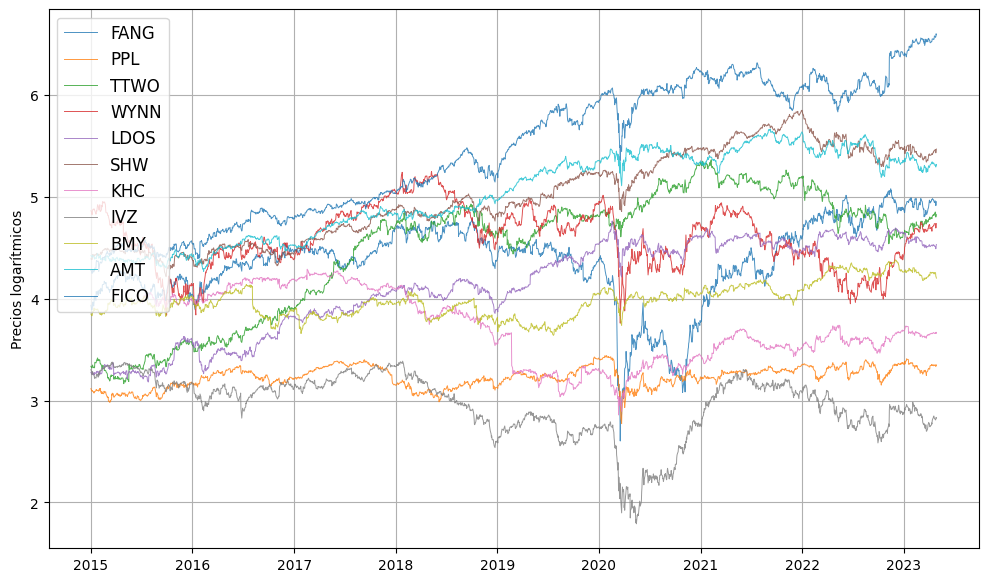

In [196]:
# Visualizamos la evolución de precios
plt.figure(figsize=(12, 7), dpi = 100)

for i in prices.columns.values:
    plt.plot(prices.index, np.log(prices[i]), lw=0.7, alpha=0.8,label=i)

plt.legend(loc='upper left', fontsize=12)
plt.grid()
plt.ylabel('Precios logarítmicos')

In [197]:
# Calculo los retornos
returns = return_fn(prices, resample_freq='BM', type = 'discrete')
returns

,FANG,PPL,TTWO,WYNN,LDOS,SHW,KHC,IVZ,BMY,AMT,FICO
Date,,,,,,,,,,,
2015-08-31,0.014710,-0.025778,-0.077581,-0.269355,0.031373,-0.076743,-0.085693,-0.109940,-0.093998,-0.030701,-0.056456
2015-09-30,-0.054034,0.075006,-0.013732,-0.292205,-0.018299,-0.129119,-0.028626,-0.084433,0.001747,-0.040790,-0.012269
2015-10-30,0.143034,0.045911,0.155587,0.316830,0.281565,0.197729,0.104704,0.062120,0.114020,0.161969,0.093136
2015-11-30,0.056609,-0.010465,0.065361,-0.096540,0.101959,0.037236,-0.047296,0.024191,0.016073,-0.027879,0.031396
2015-12-31,-0.142527,0.014062,-0.014984,0.102279,-0.023354,-0.059659,-0.004521,-0.006233,0.032188,-0.019322,-0.011234
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30,-0.075936,-0.002417,-0.014760,-0.014224,-0.034605,-0.047556,0.034562,-0.058608,-0.103762,-0.035357,-0.034112
2023-01-31,0.068285,0.013005,0.087391,0.256699,-0.060367,-0.003118,-0.004421,0.028905,0.017717,0.054423,0.112550
2023-02-28,-0.037914,-0.085473,-0.032500,0.045639,-0.017908,-0.061871,-0.039230,-0.036386,-0.050792,-0.113613,0.017178


<Axes: xlabel='Date'>

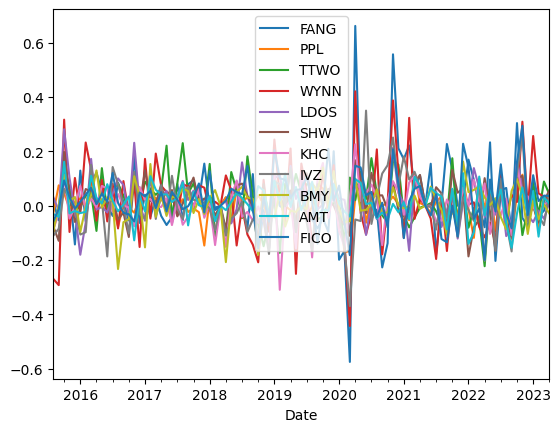

In [198]:
returns.plot()

In [199]:
# Cambiamos la frecuencia a mensual
monthly_prices = prices.asfreq('BM').ffill()
monthly_returns = monthly_prices.pct_change()

# Estimamos vetor de medias y volatilidades anualizadas
df_sample = pd.DataFrame()
df_sample['Mu'] = mean_var_estimates(returns = monthly_returns, freq = 12)[0]
df_sample['Sigma'] = np.sqrt(np.diag(mean_var_estimates(returns = monthly_returns, freq = 12)[1]))
cov_matrix = mean_var_estimates(returns = monthly_returns, freq = 12)[1]
df_sample

,Mu,Sigma
FANG,0.267242,0.510268
PPL,0.052373,0.198432
TTWO,0.247794,0.308936
WYNN,0.113246,0.497490
LDOS,0.213233,0.277435
SHW,0.171609,0.250119
KHC,-0.008676,0.282204
IVZ,0.017832,0.365687
BMY,0.073182,0.239666
AMT,0.141630,0.205136


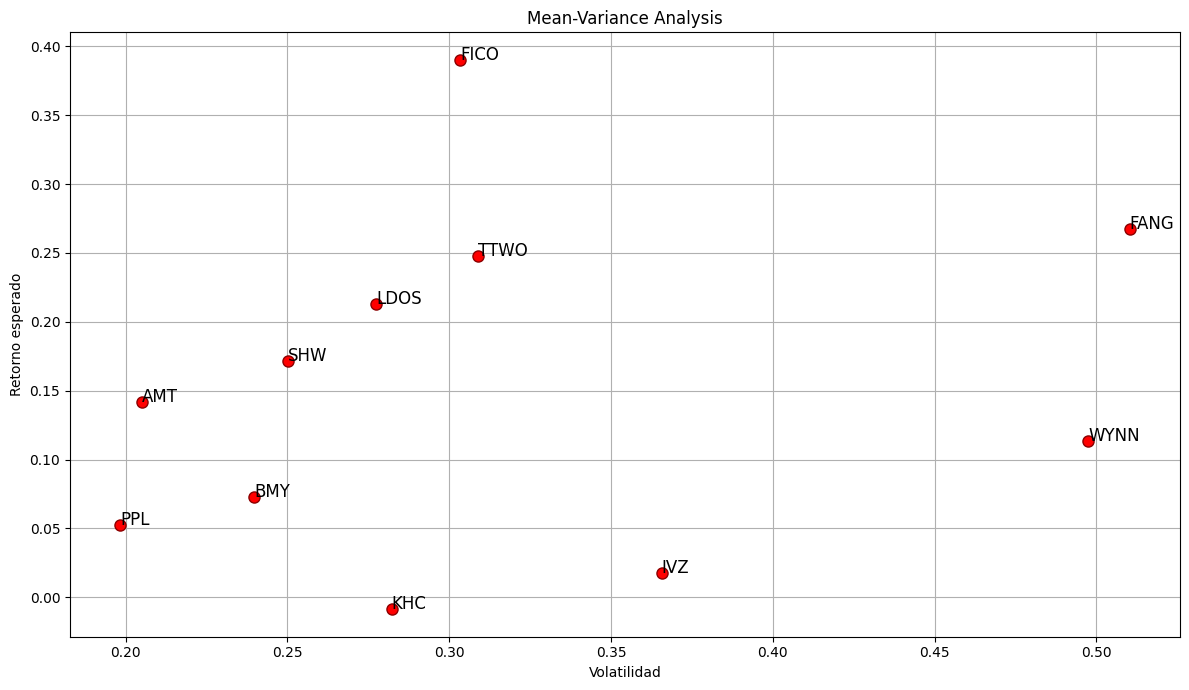

In [200]:
# Visualizacion de estas componentes del SP en el plano riesgo-retorno

fig, ax = plt.subplots(figsize = (12,7), dpi = 100, tight_layout = True)

#df_sample.plot(x='Sigma', y = 'Mu', kind = 'scatter', ax = ax)

plt.plot(df_sample.Sigma, df_sample.Mu, "o",markersize = 8, markeredgecolor= 'darkred', markerfacecolor= 'red')

plt.title('Mean-Variance Analysis')
plt.ylabel('Retorno esperado')
plt.xlabel('Volatilidad')
plt.grid()

for k, v in df_sample.iterrows():
    ax.annotate(k,v[::-1], fontsize = 12)

In [ ]:
### EJERCICIOS (OPTATIVO) ###

## Ejercicio 1
# Usar el codigo mostrado para:
# - Optimizar portafolios con Mu y Sigma de este nuevo dataset
# - Enocntrar el portafolio de minima varianza global
# - Trazar la frontera eficiente para estos nuevos Mu, Sigma
# - Hallar el portaoflio de maximo ratio de Sharpe
# - Graficar todo junto

## Ejercicio 2
# -Hallar el portafolio de maximo Sharpe usando la libreria cvxpy

# Modelos Factoriales

## Modelo CAPM

In [201]:
# Adopto como indice de mercado al SP 500 y bajo su cotizacion (ETF: SPY) como proy de portafoliode mercado:

start_date = '2015-01-01'   # Tiene que coincidir con el periodo de mis datos
end_date = '2023-04-30' # dt.datetime.now()

SPY = yf.download(
    tickers = 'SPY',
    interval = '1d',
    start = start_date,
    end = end_date,
    group_by = 'ticker',
    auto_adjust = True,
    prepost = True,
    threads = True,
    )


SPY = SPY['Close'].copy()
SPY.head()


monthly_SPY = SPY.asfreq('BM').ffill()
monthly_ret_SPY = monthly_SPY.pct_change().dropna()
monthly_ret_SPY.name = "SPY"
monthly_ret_SPY

[*********************100%***********************]  1 of 1 completed


Date
2015-02-27    0.056205
2015-03-31   -0.015706
2015-04-30    0.009834
2015-05-29    0.012857
2015-06-30   -0.020312
                ...   
2022-12-30   -0.057628
2023-01-31    0.062887
2023-02-28   -0.025143
2023-03-31    0.037078
2023-04-28    0.015975
Freq: BM, Name: SPY, Length: 99, dtype: float64

In [202]:
# Descargo mi activo libre de riesgo: BIL

start_date = '2015-01-01'   # Tiene que coincidir con el periodo de mis datos
end_date = '2023-04-30' # dt.datetime.now()

BIL = yf.download(
    tickers = 'BIL',
    interval = '1d',
    start = start_date,
    end = end_date,
    group_by = 'ticker',
    auto_adjust = True,
    prepost = True,
    threads = True,
    )


BIL = BIL['Close'].copy()
BIL.head()


monthly_BIL = BIL.asfreq('BM').ffill()
monthly_ret_BIL = monthly_BIL.pct_change().dropna()
monthly_ret_BIL.name = "BIL"
monthly_ret_BIL

[*********************100%***********************]  1 of 1 completed


Date
2015-02-27    0.000000
2015-03-31    0.000000
2015-04-30   -0.000219
2015-05-29   -0.000219
2015-06-30    0.000000
                ...   
2022-12-30    0.003626
2023-01-31    0.002842
2023-02-28    0.003458
2023-03-31    0.003991
2023-04-28    0.003630
Freq: BM, Name: BIL, Length: 99, dtype: float64

In [279]:
# Agrego la serie de SPY (mi "portafolio de mercado") y BIL (mi "activo libre de riesgo")al dataframe con mis otros activos
total = pd.concat((monthly_returns, monthly_ret_SPY, monthly_ret_BIL), axis =1).dropna()
total

,FANG,PPL,TTWO,WYNN,LDOS,SHW,KHC,IVZ,BMY,AMT,FICO,SPY,BIL
Date,,,,,,,,,,,,,
2015-08-31,0.014710,-0.025778,-0.077581,-0.269355,0.031373,-0.076743,-0.085693,-0.109940,-0.093998,-0.030701,-0.056456,-0.060950,0.000000
2015-09-30,-0.054034,0.075006,-0.013732,-0.292205,-0.018299,-0.129119,-0.028626,-0.084433,0.001747,-0.040790,-0.012269,-0.025516,-0.000438
2015-10-30,0.143034,0.045911,0.155587,0.316830,0.281565,0.197729,0.104704,0.062120,0.114020,0.161969,0.093136,0.085060,-0.000219
2015-11-30,0.056609,-0.010465,0.065361,-0.096540,0.101959,0.037236,-0.047296,0.024191,0.016073,-0.027879,0.031396,0.003655,0.000219
2015-12-31,-0.142527,0.014062,-0.014984,0.102279,-0.023354,-0.059659,-0.004521,-0.006233,0.032188,-0.019322,-0.011234,-0.017282,-0.000219
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30,-0.075936,-0.002417,-0.014760,-0.014224,-0.034605,-0.047556,0.034562,-0.058608,-0.103762,-0.035357,-0.034112,-0.057628,0.003626
2023-01-31,0.068285,0.013005,0.087391,0.256699,-0.060367,-0.003118,-0.004421,0.028905,0.017717,0.054423,0.112550,0.062887,0.002842
2023-02-28,-0.037914,-0.085473,-0.032500,0.045639,-0.017908,-0.061871,-0.039230,-0.036386,-0.050792,-0.113613,0.017178,-0.025143,0.003458


In [204]:
# Calculamos los betas con su formula cerrada (
def beta_function(asset, factor):
    cov_mat = pd.concat((asset, factor), axis = 1).cov()
    beta = cov_mat.iloc[0,1]/(cov_mat.iloc[1,1])
    return beta

# Ejemplo de beta para un activo en particular
asset_name = 'PPL'
beta_particular = beta_function(total[asset_name], total.SPY)
print(f"Beta de {asset_name} contra el {total.SPY.name} es: {beta_particular}.")
# % (mvg_ret*100))

Beta de PPL contra el SPY es: 0.7283688391574521.


In [205]:
# Varianzas y covarianzas contra el mercado:
asset_name = 'PPL'
pd.concat((total[asset_name], total["SPY"]), axis = 1).cov()

,PPL,SPY
PPL,0.003337,0.001583
SPY,0.001583,0.002173


In [280]:
# la regresion es estadisticamente significativa?

from statsmodels import regression
import statsmodels.api as sm

asset_name = 'PPL'
y = total[asset_name]-total.BIL
X = sm.add_constant(total.SPY - total.BIL)
CAPM_regression = regression.linear_model.OLS(y, X).fit()
CAPM_beta = CAPM_regression.params.iloc[1]

print(CAPM_regression.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     48.39
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           5.20e-10
Time:                        14:39:53   Log-Likelihood:                 153.44
No. Observations:                  93   AIC:                            -302.9
Df Residuals:                      91   BIC:                            -297.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.005     -0.576      0.5

In [281]:
# Cp de Mallow
N = len(y)  # Cant de observaciones
p = len(X.columns)      # Cant de covariables (intercept + UNA covariable)
RSS = CAPM_regression.ssr
s2 = (1/(N-p-1)) * RSS

#Computing
Cp = (1/N) * (RSS + 2 * p * s2 )
Cp

0.002256065860150771

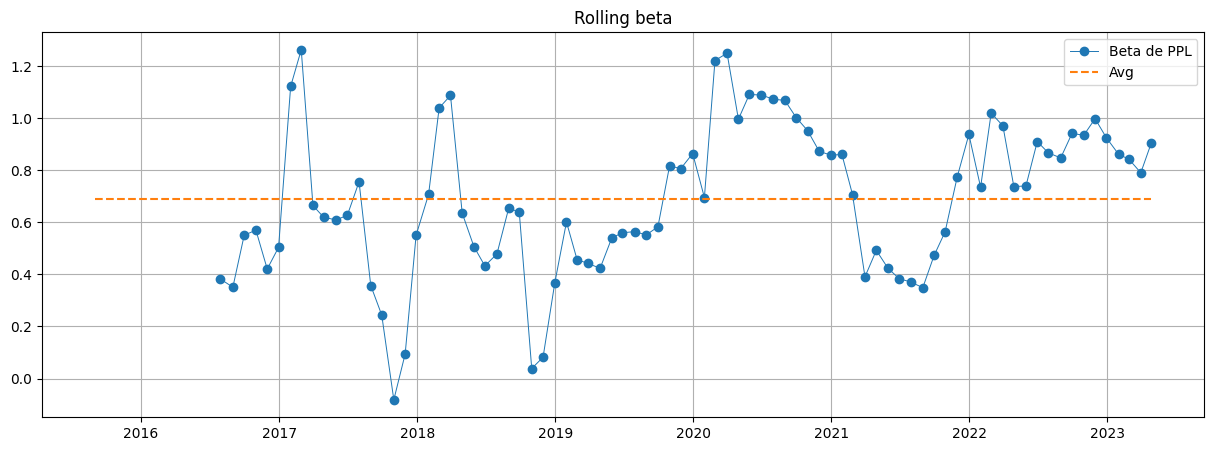

In [250]:
total['beta'] = total[asset_name].rolling(12).cov(total['SPY']) / total['SPY'].rolling(12).var()

fig,ax = plt.subplots(figsize = (15,5), dpi = 100)
data_line = ax.plot(total.index,total.beta, lw = 0.7, label=f'Beta de {asset_name}', marker='o')
mean_line = ax.plot(total.index,[np.mean(total.beta)]*len(total.beta), label='Avg', linestyle='--')

# Make a legend
legend = ax.legend(loc='upper right')
plt.title("Rolling beta")
plt.grid()
plt.show()

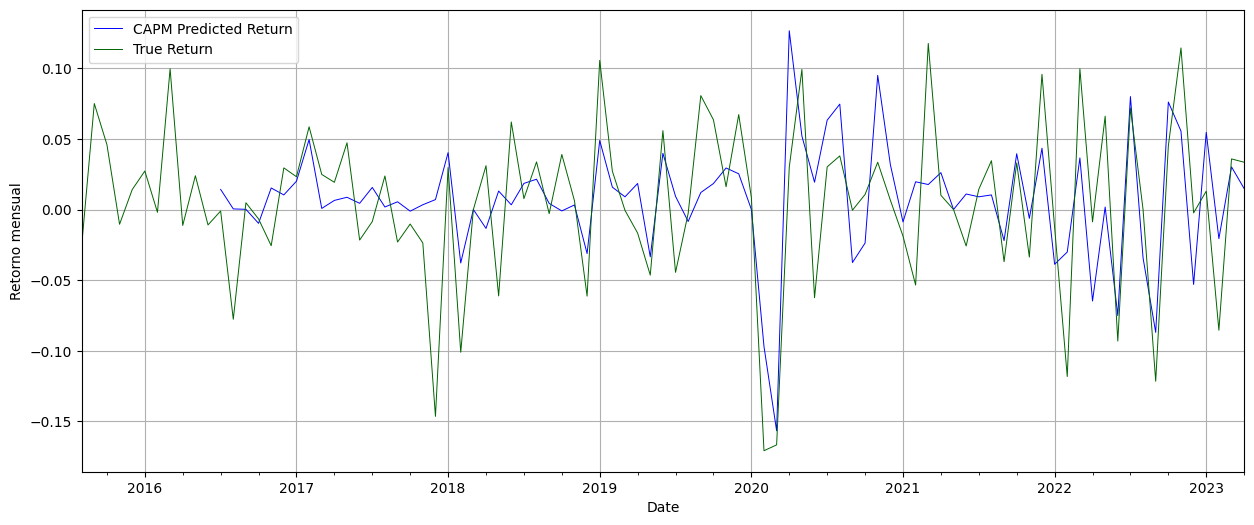

In [249]:
forecast = total.BIL + total.beta*(total.SPY - total.BIL) # CAPM equation

fig, ax = plt.subplots(figsize = (15,6), dpi = 100)

forecast.plot(lw = 0.7, color='blue', label ="CAPM Predicted Return")
total[asset_name].plot(color='darkgreen', lw = 0.7, label = 'True Return')
#R.plot(color='Y')
plt.legend()

plt.ylabel('Retorno mensual')
plt.grid()

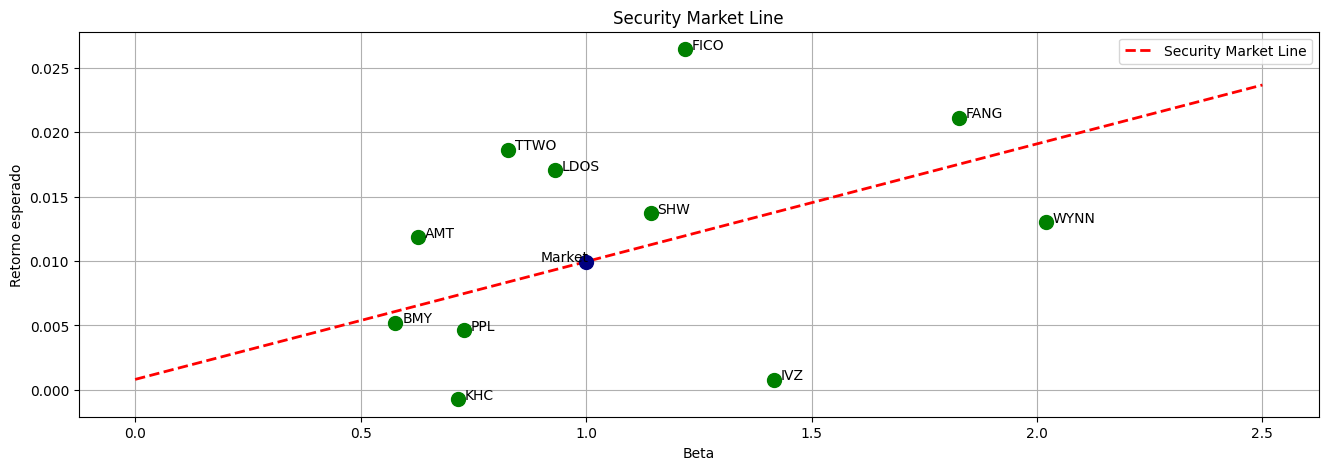

In [284]:
risk_free_rate = np.mean(total.BIL)

# We have two coordinates that we use to map the SML: (0, risk-free rate) and (1, market return)

eqn_of_the_line = lambda x : ( (np.mean(total.SPY)-risk_free_rate) / 1.0) * x + risk_free_rate
xrange = np.linspace(0., 2.5, num=2)

plt.figure(figsize=(16,5))
plt.plot(xrange, [eqn_of_the_line(x) for x in xrange], color='red', linestyle='--', linewidth=2, label = 'Security Market Line' )

plt.plot([1], [np.mean(total.SPY)], marker='o', color='navy', markersize=10)
plt.annotate('Market', xy=(1, np.mean(total.SPY)), xytext=(0.9, np.mean(total.SPY)+0.00004))

#monthly_returns.columns = map(lambda x: x.symbol, monthly_returns.columns)

betas = [
    regression.linear_model.OLS(total[asset]-risk_free_rate,
                                sm.add_constant(total.SPY-risk_free_rate)).fit().params[1]
    for asset in monthly_returns.columns]

for asset, beta in zip(monthly_returns, betas):
    plt.plot([beta], [np.mean(total[asset])], marker='o', color='g', markersize=10)
    plt.annotate(
        asset,
        xy=(beta, np.mean(total[asset])),
        xytext=(beta + 0.015, np.mean(total[asset]) + 0.000025)
    )

plt.title("Security Market Line")
plt.xlabel("Beta")
plt.ylabel("Retorno esperado")
plt.legend()
plt.grid()

### Modelos Factores: 3 y 5 de Fama French

In [117]:
!pip install pandas_datareader

  Using cached pandas_datareader-0.10.0-py3-none-any.whl (109 kB)


In [214]:
# Importo librerias a utilizar
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web

In [215]:
# La libreria padans_datareader tiene una funcionalidad que nos permite contectar directamente con la pagina de Kenneth French y descargar las series de los factores de sus modelos

# Estos son los datasets disponibles, asociados a los distintos mdoelos y a distitnas frecuencias
get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_OP_Daily',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 'Portfolios_Formed_on_INV_Daily',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portf

In [285]:
# Descargo la serie de factores diarios del modelo de 5 factores, desde el comienzo del 2015.

factors = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench',start="2015")
factors = factors[0]

# Como los datos son diarios, debo acumularlos para muestrear mensualmente (no puedo simplemente muestrear retornos en otroa frecuencia, como si puedo hacerlo con precios!)
factors_monthly = factors.add(100).div(100).cumprod().resample('M').last().pct_change()
factors_monthly.columns = ['Market', 'SMB', 'HML','RMW', 'CMA', 'rf']
factors_monthly = factors_monthly.dropna()

factors_monthly

,Market,SMB,HML,RMW,CMA,rf
Date,,,,,,
2015-02-28,0.061292,0.002533,-0.017358,-0.011001,-0.017205,0.000000
2015-03-31,-0.011320,0.031054,-0.004148,0.000541,-0.005428,0.000000
2015-04-30,0.005906,-0.030052,0.018237,0.000280,-0.007436,0.000000
2015-05-31,0.013387,0.007927,-0.010902,-0.017182,-0.004219,0.000000
2015-06-30,-0.015031,0.029800,-0.007665,0.003857,-0.015228,0.000000
...,...,...,...,...,...,...
2023-01-31,0.066522,0.041927,-0.037356,-0.025357,-0.040188,0.003405
2023-02-28,-0.025819,0.006394,-0.010102,0.005362,-0.015881,0.003426
2023-03-31,0.024531,-0.067004,-0.087104,0.017666,-0.020572,0.003686


In [286]:
# Son los valores de los factores a fi nde mes, pero los dias estna corridos por uno. Podemos corregir esto sin perdida de generalizad asi podemos unir los dataframes
factors_monthly.index = monthly_returns.index

factors_monthly

,Market,SMB,HML,RMW,CMA,rf
Date,,,,,,
2015-01-30,0.061292,0.002533,-0.017358,-0.011001,-0.017205,0.000000
2015-02-27,-0.011320,0.031054,-0.004148,0.000541,-0.005428,0.000000
2015-03-31,0.005906,-0.030052,0.018237,0.000280,-0.007436,0.000000
2015-04-30,0.013387,0.007927,-0.010902,-0.017182,-0.004219,0.000000
2015-05-29,-0.015031,0.029800,-0.007665,0.003857,-0.015228,0.000000
...,...,...,...,...,...,...
2022-12-30,0.066522,0.041927,-0.037356,-0.025357,-0.040188,0.003405
2023-01-31,-0.025819,0.006394,-0.010102,0.005362,-0.015881,0.003426
2023-02-28,0.024531,-0.067004,-0.087104,0.017666,-0.020572,0.003686


In [288]:
# Como vamos a predecir los retornos mediante factores, removemos el ultimo retorno observado, pero dejamos la ultima observacion de factores

display(monthly_returns[:-1].tail())
display(factors_monthly.tail())

# Creo un dataframe nuevo con el valor de los retornos de los activos completo ecepto el ultimo registro (que vamos ap redecir con factores)
monthly_returns_factores = total[:-1]
monthly_returns_factores

,FANG,PPL,TTWO,WYNN,LDOS,SHW,KHC,IVZ,BMY,AMT,FICO
Date,,,,,,,,,,,
2022-11-30,-0.044935,0.114383,-0.107951,0.309233,0.076189,0.110085,0.033486,0.261757,0.036272,0.067860,0.294211
2022-12-30,-0.075936,-0.002417,-0.014760,-0.014224,-0.034605,-0.047556,0.034562,-0.058608,-0.103762,-0.035357,-0.034112
2023-01-31,0.068285,0.013005,0.087391,0.256699,-0.060367,-0.003118,-0.004421,0.028905,0.017717,0.054423,0.112550
2023-02-28,-0.037914,-0.085473,-0.032500,0.045639,-0.017908,-0.061871,-0.039230,-0.036386,-0.050792,-0.113613,0.017178
2023-03-31,-0.018462,0.035805,0.089000,0.032666,-0.047896,0.015451,0.003542,-0.071348,0.005075,0.031968,0.037349


,Market,SMB,HML,RMW,CMA,rf
Date,,,,,,
2022-12-30,0.066522,0.041927,-0.037356,-0.025357,-0.040188,0.003405
2023-01-31,-0.025819,0.006394,-0.010102,0.005362,-0.015881,0.003426
2023-02-28,0.024531,-0.067004,-0.087104,0.017666,-0.020572,0.003686
2023-03-31,0.006173,-0.025581,-0.001067,0.022391,0.028813,0.003426
2023-04-28,0.003587,-0.004156,-0.076039,-0.022973,-0.066598,0.003526


,FANG,PPL,TTWO,WYNN,LDOS,SHW,KHC,IVZ,BMY,AMT,FICO,SPY,BIL
Date,,,,,,,,,,,,,
2015-08-31,0.014710,-0.025778,-0.077581,-0.269355,0.031373,-0.076743,-0.085693,-0.109940,-0.093998,-0.030701,-0.056456,-0.060950,0.000000
2015-09-30,-0.054034,0.075006,-0.013732,-0.292205,-0.018299,-0.129119,-0.028626,-0.084433,0.001747,-0.040790,-0.012269,-0.025516,-0.000438
2015-10-30,0.143034,0.045911,0.155587,0.316830,0.281565,0.197729,0.104704,0.062120,0.114020,0.161969,0.093136,0.085060,-0.000219
2015-11-30,0.056609,-0.010465,0.065361,-0.096540,0.101959,0.037236,-0.047296,0.024191,0.016073,-0.027879,0.031396,0.003655,0.000219
2015-12-31,-0.142527,0.014062,-0.014984,0.102279,-0.023354,-0.059659,-0.004521,-0.006233,0.032188,-0.019322,-0.011234,-0.017282,-0.000219
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,-0.044935,0.114383,-0.107951,0.309233,0.076189,0.110085,0.033486,0.261757,0.036272,0.067860,0.294211,0.055592,0.003152
2022-12-30,-0.075936,-0.002417,-0.014760,-0.014224,-0.034605,-0.047556,0.034562,-0.058608,-0.103762,-0.035357,-0.034112,-0.057628,0.003626
2023-01-31,0.068285,0.013005,0.087391,0.256699,-0.060367,-0.003118,-0.004421,0.028905,0.017717,0.054423,0.112550,0.062887,0.002842


In [289]:
# Combino los dtafarames de facotres hasta el ultimo y el de retornos hasta el anteultimo
monthly_returns_factores = pd.concat([monthly_returns_factores, factors_monthly], axis = 1)

display(monthly_returns_factores.head())
display(monthly_returns_factores.tail())

,FANG,PPL,TTWO,WYNN,LDOS,SHW,KHC,IVZ,BMY,AMT,FICO,SPY,BIL,Market,SMB,HML,RMW,CMA,rf
Date,,,,,,,,,,,,,,,,,,,
2015-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061292,0.002533,-0.017358,-0.011001,-0.017205,0.0
2015-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011320,0.031054,-0.004148,0.000541,-0.005428,0.0
2015-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005906,-0.030052,0.018237,0.000280,-0.007436,0.0
2015-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013387,0.007927,-0.010902,-0.017182,-0.004219,0.0
2015-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.015031,0.029800,-0.007665,0.003857,-0.015228,0.0


,FANG,PPL,TTWO,WYNN,LDOS,SHW,KHC,IVZ,BMY,AMT,FICO,SPY,BIL,Market,SMB,HML,RMW,CMA,rf
Date,,,,,,,,,,,,,,,,,,,
2022-12-30,-0.075936,-0.002417,-0.014760,-0.014224,-0.034605,-0.047556,0.034562,-0.058608,-0.103762,-0.035357,-0.034112,-0.057628,0.003626,0.066522,0.041927,-0.037356,-0.025357,-0.040188,0.003405
2023-01-31,0.068285,0.013005,0.087391,0.256699,-0.060367,-0.003118,-0.004421,0.028905,0.017717,0.054423,0.112550,0.062887,0.002842,-0.025819,0.006394,-0.010102,0.005362,-0.015881,0.003426
2023-02-28,-0.037914,-0.085473,-0.032500,0.045639,-0.017908,-0.061871,-0.039230,-0.036386,-0.050792,-0.113613,0.017178,-0.025143,0.003458,0.024531,-0.067004,-0.087104,0.017666,-0.020572,0.003686
2023-03-31,-0.018462,0.035805,0.089000,0.032666,-0.047896,0.015451,0.003542,-0.071348,0.005075,0.031968,0.037349,0.037078,0.003991,0.006173,-0.025581,-0.001067,0.022391,0.028813,0.003426
2023-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003587,-0.004156,-0.076039,-0.022973,-0.066598,0.003526


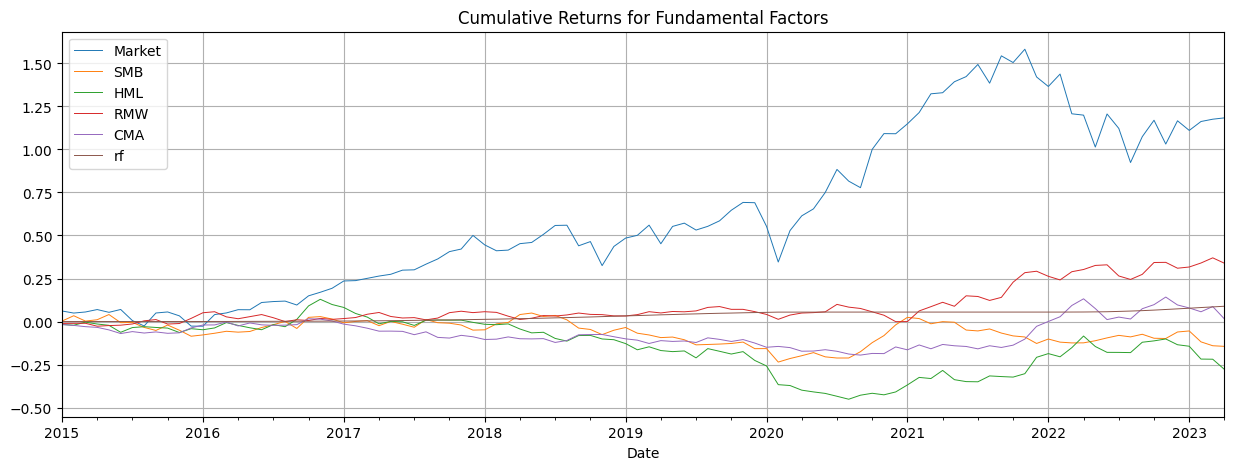

In [291]:
# Visualizo el retorno acumulado por factor

fig, ax = plt.subplots(figsize = (15,5), dpi = 100)
((factors_monthly + 1).cumprod() - 1).plot(subplots=False,
                                                title='Cumulative Returns for Fundamental Factors',
                                                lw = 0.7, label = True, ax = ax)
plt.grid()
plt.show()

In [296]:
# Estimacion de sensibilidades
# Creo la matriz de disenio (paral a regresion lineal
monthly_returns_factores = monthly_returns_factores.dropna()
X = sm.add_constant(monthly_returns_factores[['Market', 'SMB', 'HML','RMW', 'CMA']])

X

,const,Market,SMB,HML,RMW,CMA
Date,,,,,,
2015-08-31,1.0,-0.031007,-0.029344,0.005228,0.018443,-0.008802
2015-09-30,1.0,0.077370,-0.018172,-0.004635,0.007357,0.006887
2015-10-30,1.0,0.005764,0.032984,-0.003829,-0.025763,-0.008516
2015-11-30,1.0,-0.021455,-0.030666,-0.026804,0.003113,0.003122
2015-12-31,1.0,-0.057644,-0.036749,0.023953,0.030207,0.030240
...,...,...,...,...,...,...
2022-11-30,1.0,-0.063749,-0.001577,0.012524,0.000636,0.040216
2022-12-30,1.0,0.066522,0.041927,-0.037356,-0.025357,-0.040188
2023-01-31,1.0,-0.025819,0.006394,-0.010102,0.005362,-0.015881


In [297]:
# Calculo la regresion y su reporte
# es fundamental que X e y tengan el mismo indice
asset_name = 'PPL'
y = monthly_returns_factores[asset_name].dropna()
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPL   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     1.802
Date:                Thu, 29 Jun 2023   Prob (F-statistic):              0.121
Time:                        14:49:09   Log-Likelihood:                 136.49
No. Observations:                  92   AIC:                            -261.0
Df Residuals:                      86   BIC:                            -245.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0085      0.006      1.370      0.1

In [299]:
# Volvemos a definir la función para calcular las sensibilidades (betas)
# factor exposure
Betas = pd.DataFrame(index=total[monthly_returns.columns].columns, dtype=np.float32)
epsilon = pd.DataFrame(index=total.index[:-1], dtype=np.float32)

# Voy a guardar las betas de cada activo para cada factor
Betas

# voy a guardar el retorno idiosincratico en cada instante (los residuos de la regresion)
epsilon

""
Date
2015-08-31
2015-09-30
2015-10-30
2015-11-30
2015-12-31
...
2022-11-30
2022-12-30
2023-01-31


In [300]:
assets = monthly_returns.columns

for i in assets:
    y = monthly_returns_factores.loc[:,i]
    y_inlier = y[np.abs(y - y.mean())<=(3*y.std())]
    x_inlier = X[np.abs(y - y.mean())<=(3*y.std())]
    result = sm.OLS(y_inlier, x_inlier).fit()

    Betas.loc[i,"MKT_beta"] = result.params[1]
    Betas.loc[i,"SMB_beta"] = result.params[2]
    Betas.loc[i,"HML_beta"] = result.params[3]
    Betas.loc[i,"RMW_beta"] = result.params[4]
    Betas.loc[i,"CMA_beta"] = result.params[5]

    epsilon.loc[:,i] = y - (X.iloc[:,0] * result.params[0] +
                            X.iloc[:,1] * result.params[1] +
                            X.iloc[:,2] * result.params[2] +
                            X.iloc[:,3] * result.params[3] +
                            X.iloc[:,4] * result.params[4] +
                            X.iloc[:,5] * result.params[5])

In [301]:
Retornos = total[monthly_returns.columns][:-1]
Factores = monthly_returns_factores[['Market', 'SMB', 'HML','RMW', 'CMA']]

In [308]:
w = np.ones([1,Retornos.shape[1]])/Retornos.shape[1]

def compute_common_factor_variance(factors, factor_exposures, w):
    B = np.asarray(factor_exposures)
    F = np.asarray(factors)
    Cov_Factores = np.asarray(factors.cov())

    return w @ B @ Cov_Factores @ B.T @ w.T

common_factor_variance = compute_common_factor_variance(Factores, Betas, w)[0][0]
print(f"Common Factor Variance: {common_factor_variance:.6f}")


Common Factor Variance: 0.000061


In [313]:
def compute_specific_variance(epsilon, w):

    D = np.diag(np.asarray(epsilon.var())) * epsilon.shape[0] / (epsilon.shape[0]-1)

    return w.dot(D).dot(w.T)

specific_variance = compute_specific_variance(epsilon, w)[0][0]
print(f"Specific Variance: {specific_variance:.6f}")

common_factor_pct = common_factor_variance / (common_factor_variance + specific_variance) * 100.0
print(f"Percentage of Portfolio Variance Due to Common Factor Risk: {common_factor_pct:.4f}%")
print()
specific_factor_pct = specific_variance / (common_factor_variance + specific_variance) * 100.0
print(f"Percentage of Portfolio Variance Due to Specific Risk: {specific_factor_pct:.4f}%")

Specific Variance: 0.000831
Percentage of Portfolio Variance Due to Common Factor Risk: 6.8781%

Percentage of Portfolio Variance Due to Specific Risk: 93.1219%
